In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.cluster import KMeans

from shapkit_nbdev.shapley_values import ShapleyValues
from shapkit_nbdev.inspector import inspector
from shapkit_nbdev.monte_carlo_shapley import MonteCarloShapley
from shapkit_nbdev.sgd_shapley import SGDshapley

%load_ext autoreload
%autoreload 2

# Load dataset

In [2]:
from sklearn.datasets import load_wine
wine = load_wine()
columns = wine.feature_names
target_names = wine.target_names
X = pd.DataFrame(wine.data, columns=columns)
y = wine.target
print("Classes: {0}".format(np.unique(y)))
X.head(3)

Classes: [0 1 2]


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0



# Train a ML model

In [3]:
model = KMeans(n_clusters=3, random_state=0).fit(X)

# Define the game

In [7]:
d = X.shape[1]
n = 2**d - 2
d, n

(13, 8190)

In [8]:
fc = lambda x: model.predict(x.reshape(1,-1))[0]

In [9]:
r_class, x_class = 0, 0
while x_class == r_class:
    idx_r, idx_x = np.random.choice(np.arange(len(X)), size=2, replace=False)
    r = X.iloc[idx_r,:]
    x = X.iloc[idx_x,:]
    r_class = fc(r.values)
    x_class = fc(x.values)
fc_class = lambda x: 1 if int(fc(x)) == int(x_class) else 0

In [10]:
print(r)
print()
print("Group Prediction for r: {0:.0f}".format(fc(r.values)))

alcohol                           13.76
malic_acid                         1.53
ash                                2.70
alcalinity_of_ash                 19.50
magnesium                        132.00
total_phenols                      2.95
flavanoids                         2.74
nonflavanoid_phenols               0.50
proanthocyanins                    1.35
color_intensity                    5.40
hue                                1.25
od280/od315_of_diluted_wines       3.00
proline                         1235.00
Name: 33, dtype: float64

Group Prediction for r: 1


In [11]:
print(x)
print()
print("Group Prediction for x: {0:.0f}".format(fc(x.values)))

alcohol                          12.60
malic_acid                        1.34
ash                               1.90
alcalinity_of_ash                18.50
magnesium                        88.00
total_phenols                     1.45
flavanoids                        1.36
nonflavanoid_phenols              0.29
proanthocyanins                   1.35
color_intensity                   2.45
hue                               1.04
od280/od315_of_diluted_wines      2.77
proline                         562.00
Name: 101, dtype: float64

Group Prediction for x: 2


# Exact Shapley Values

In [12]:
true_shap = ShapleyValues(x=x, fc=fc_class, r=r)

100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


In [13]:
true_shap

alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         1.0
dtype: float64

# Approximation methods

## Monte Carlo 

In [14]:
mc_shap = MonteCarloShapley(x=x, fc=fc_class, r=r, n_iter=100)
mc_shap

  9%|▉         | 9/100 [00:00<00:01, 87.71it/s]

new dimension 12


100%|██████████| 100/100 [00:00<00:00, 111.35it/s]


alcohol                         0.0
malic_acid                      0.0
ash                             0.0
alcalinity_of_ash               0.0
magnesium                       0.0
total_phenols                   0.0
flavanoids                      0.0
nonflavanoid_phenols            0.0
proanthocyanins                 0.0
color_intensity                 0.0
hue                             0.0
od280/od315_of_diluted_wines    0.0
proline                         1.0
dtype: float64

## SGD

In [15]:
sgd_est = SGDshapley(d, C=y.max())
sgd_shap = sgd_est.sgd(x=x, fc=fc_class, r=r, n_iter=1000, step=.1, step_type="sqrt")
sgd_shap

100%|██████████| 1000/1000 [00:00<00:00, 2156.65it/s]


alcohol                         0.008458
malic_acid                      0.003432
ash                             0.023151
alcalinity_of_ash               0.011314
magnesium                       0.010650
total_phenols                  -0.015737
flavanoids                     -0.007342
nonflavanoid_phenols           -0.001957
proanthocyanins                 0.011753
color_intensity                 0.005759
hue                            -0.005632
od280/od315_of_diluted_wines   -0.006361
proline                         0.962512
dtype: float64

# Comparison with several references 

In [17]:
n_ref = 100
pred = model.predict(X)
idx_ref = np.argwhere(pred != x_class).flatten()
pool_ref = X.iloc[idx_ref[:n_ref]]
pool_ref.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [18]:
x_attributes = [feature + " = " + str(val) for feature, val in x.iteritems()]
pool_shapley = pd.DataFrame(np.zeros((n_ref, d)), columns=x_attributes)
for i in range(n_ref):
    mc_shap = MonteCarloShapley(x=x, fc=fc_class, r=r, n_iter=100)
    pool_shapley.iloc[i,:] = mc_shap.values

  8%|▊         | 8/100 [00:00<00:01, 76.25it/s]

new dimension 12


  9%|▉         | 9/100 [00:00<00:01, 85.95it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 108.82it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 109.61it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 103.40it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 101.79it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 108.05it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 111.37it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 111.99it/s]

new dimension 12


 10%|█         | 10/100 [00:00<00:00, 95.95it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 115.47it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.52it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.15it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 112.56it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.97it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 103.60it/s]

new dimension 12


 14%|█▍        | 14/100 [00:00<00:00, 132.20it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 105.51it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.61it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 113.64it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.63it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 115.69it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 123.64it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.41it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 118.97it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.21it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 129.68it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.72it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 126.82it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.93it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.24it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 129.10it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.26it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.57it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.52it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.69it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.41it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.68it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 126.31it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.85it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.80it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 113.84it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.53it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.93it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.65it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.95it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.98it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 119.59it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.13it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 109.94it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.22it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.82it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.62it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.29it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 110.82it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.46it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 102.21it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.71it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 110.72it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.63it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 113.72it/s]

new dimension 12


  9%|▉         | 9/100 [00:00<00:01, 89.58it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.60it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 106.51it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.01it/s]

new dimension 12


 14%|█▍        | 14/100 [00:00<00:00, 131.74it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 119.52it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 126.84it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.88it/s]

new dimension 12


 14%|█▍        | 14/100 [00:00<00:00, 131.28it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.84it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 118.61it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.88it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 107.29it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.41it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 105.63it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.39it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 109.67it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.69it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 106.20it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 125.01it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.95it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 119.73it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 127.49it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.07it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.23it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 123.82it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.52it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.15it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.76it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 124.05it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.96it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.36it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 115.44it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.63it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 126.38it/s]

new dimension 12


 12%|█▏        | 12/100 [00:00<00:00, 117.08it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 122.32it/s]

new dimension 12


 11%|█         | 11/100 [00:00<00:00, 106.62it/s]

new dimension 12


 13%|█▎        | 13/100 [00:00<00:00, 121.19it/s]

new dimension 12


100%|██████████| 100/100 [00:00<00:00, 124.07it/s]


In [19]:
mean_pool_shap = pool_shapley.mean(axis=0)
mean_pool_shap

alcohol = 12.6                         0.0
malic_acid = 1.34                      0.0
ash = 1.9                              0.0
alcalinity_of_ash = 18.5               0.0
magnesium = 88.0                       0.0
total_phenols = 1.45                   0.0
flavanoids = 1.36                      0.0
nonflavanoid_phenols = 0.29            0.0
proanthocyanins = 1.35                 0.0
color_intensity = 2.45                 0.0
hue = 1.04                             0.0
od280/od315_of_diluted_wines = 2.77    0.0
proline = 562.0                        1.0
dtype: float64

In [20]:
np.sum(mean_pool_shap)

1.0

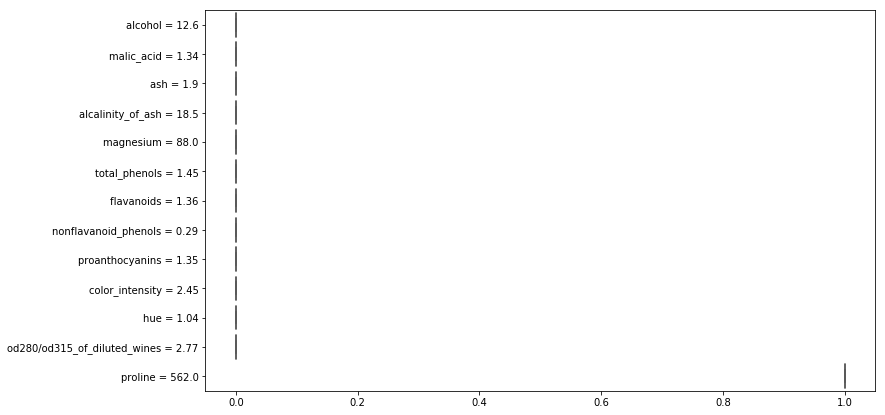

In [21]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=pool_shapley, orient="h", palette="Set2")
plt.show()